In [1]:
import numpy as np
from scipy.stats import norm
import statsmodels.stats.api as sms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

## Hormone data

In [3]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
h_df['Pl_change'] = (h_df['Pl_T1']-h_df['Pl_T0'])/h_df['Pl_T0']
h_df['T_change'] = (h_df['T_T1']-h_df['T_T0'])/h_df['T_T0']
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#TPl_change
ids = pd.read_excel('EE_subj_list.xlsx', header=None, usecols = [1,2])
ids.columns = ['ID', 'Subjects']
ids = ids.join(TPl_change, on = ['ID'])

## Endowment data

In [4]:
df = pd.read_excel('Endowment_list.xlsx')
df1 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTA_Test','WTA_Plac'], value_name='WTA')
df1['Test'] = 0
df1.loc[df1.variable.str.contains('Test'),'Test'] = 1
df1.drop('variable', axis=1, inplace = True)
df2 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTP_Test','WTP_Plac'], value_name='WTP')
df2['Test'] = 0
df2.loc[df2.variable.str.contains('Test'),'Test'] = 1
df2.drop('variable', axis=1, inplace = True)
df = df1.merge(df2)
df.drop(df.index[(df.WTA.isin([0, np.nan])) | (df.WTP.isin([0, np.nan]))], inplace = True)
df['WTA/WTP'] = df.WTA/df.WTP
df = pd.merge(df, ids, on = 'Subjects')
df.loc[df.Test==0, 'TPl_change'] = 0
df = df.drop(['Market Price','WTA','WTP','ID'],axis=1)

There are number of outliers in the data, when WTA exceed WTP 20 times and more. We decided to clip these values to the reasonable upper boarder equal to mean value with 3 standart deviations added

In [5]:
max_rel = df['WTA/WTP'].mean()+3*df['WTA/WTP'].std()
df['WTAPcorr'] = df['WTA/WTP']
df.loc[df['WTA/WTP']>max_rel,'WTAPcorr'] = max_rel

In [6]:
df["ItemCodes"] = pd.Categorical(df['Item']).codes
df["SubjectsCode"] = pd.Categorical(df['Subjects']).codes
df["TypeCode"] = pd.Categorical(df['Type']).codes

In [7]:
df.head()

,Subjects,Item,Type,Test,WTA/WTP,TPl_change,WTAPcorr,ItemCodes,SubjectsCode,TypeCode
0,Subj1,gin,h,1,1.000000,2.655172,1.000000,8,0,0
1,Subj1,beer set,h,1,1.500000,2.655172,1.500000,1,0,0
2,Subj1,video game,h,1,1.000000,2.655172,1.000000,26,0,0
3,Subj1,helicopter,h,1,1.333333,2.655172,1.333333,10,0,0
4,Subj1,car model,h,1,1.250000,2.655172,1.250000,6,0,0


## General comparison hedonic and utilitarian goods

From the picture we can see little difference between hedonic and utilitarian goods

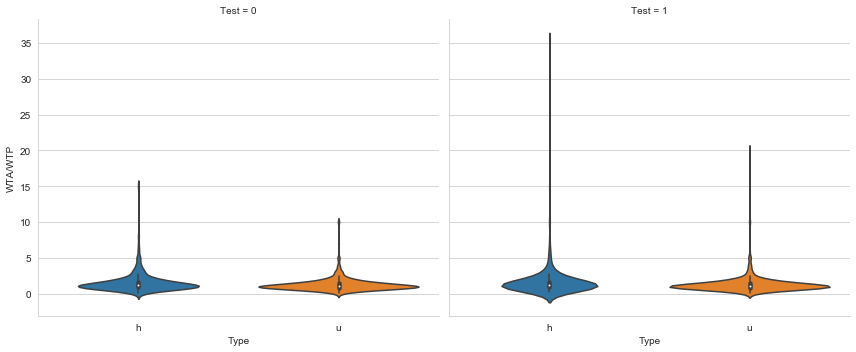

In [8]:
g = sns.catplot(x="Type", y="WTA/WTP",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);

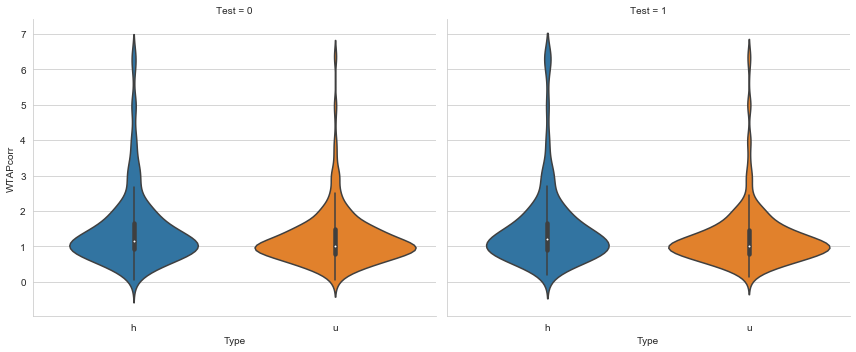

In [9]:
g = sns.catplot(x="Type", y="WTAPcorr",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);

Which one is better? I prefer the last one, but you can change below

In [10]:
df.groupby(['Type','Test'])['WTA/WTP','WTAPcorr'].agg(['mean','std'])

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


WTA/WTP            WTAPcorr          
               mean       std      mean       std
Type Test                                        
h    0     1.546391  1.381236  1.504126  1.091903
     1     1.723183  2.489548  1.534656  1.158717
u    0     1.261989  0.927713  1.246495  0.805767
     1     1.310404  1.256742  1.268190  0.860240

There is a small problem with the equal variance assumption here. Variance assuming equal variance in both data sets, but here it is violated

In [11]:
cm = sms.CompareMeans(sms.DescrStatsW(df.loc[(df.Test == 0)&(df.Type == 'h'),'WTAPcorr'].values), sms.DescrStatsW(df.loc[(df.Test == 0)&(df.Type == 'u'),'WTAPcorr'].values))
cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.2576,0.060,4.284,0.000,0.140,0.376


In [12]:
cm = sms.CompareMeans(sms.DescrStatsW(df.loc[(df.Test == 1)&(df.Type == 'h'),'WTAPcorr'].values), sms.DescrStatsW(df.loc[(df.Test == 1)&(df.Type == 'u'),'WTAPcorr'].values))
cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.2665,0.063,4.211,0.000,0.142,0.391


In both conditions there is difference between type of goods.
We can draw nice pictures from Bayesian perspective, and it is not sensitive to equal variance assumption

### Placebo condition

In [14]:
with pm.Model() as model_pl:
    
    df_sel = df[df.Test==0].reset_index()
    mean = pm.Normal('mean', mu=df_sel.WTAPcorr.mean(), sd=2*df_sel.WTAPcorr.std(),  shape=(2,))
    sigma = pm.HalfCauchy('sd', beta=10, shape=(2,))
    WTAP = pm.Normal('WTAP', mu=mean[df_sel['TypeCode'].values], sd=sigma[df_sel['TypeCode'].values], observed=df_sel['WTAPcorr'].values)

    trace_pl = pm.sample(4000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:04<00:00, 4419.67draws/s]


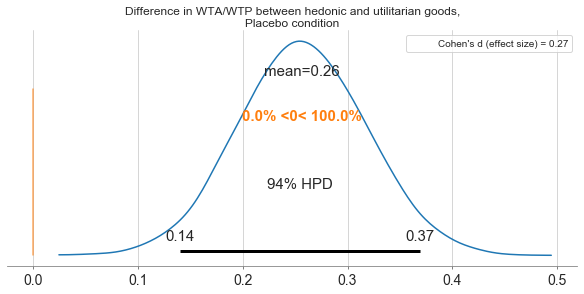

In [19]:
def effect_size(trace, condition = 'Placebo'):
    means_diff = trace['mean'][:, 0] - trace['mean'][:, 1]
    d_cohen = (means_diff / np.sqrt((trace['sd'][:, 0]**2 +
    trace['sd'][:, 1]**2) / 2)).mean()
    _, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    az.plot_posterior(means_diff, ref_val=0, ax=ax)
    ax.set_title(f'Difference in WTA/WTP between hedonic and utilitarian goods,\n {condition} condition')
    ax.plot(0, label=f"Cohen's d (effect size) = {d_cohen:.2f}",alpha=0)
    ax.legend();
effect_size(trace_pl)    

There is difference but effect size is small (for values below 0.5 effects is considered as a small)

### Under testosterone

In [17]:
with pm.Model() as model_test:
    
    df_sel = df[df.Test==1].reset_index()
    mean = pm.Normal('mean', mu=df_sel.WTAPcorr.mean(), sd=2*df_sel.WTAPcorr.std(),  shape=(2,))
    sigma = pm.HalfCauchy('sd', beta=10, shape=(2,))
    WTAP = pm.Normal('WTAP', mu=mean[df_sel['TypeCode'].values], sd=sigma[df_sel['TypeCode'].values], observed=df_sel['WTAPcorr'].values)

    trace_test = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:04<00:00, 4555.43draws/s]


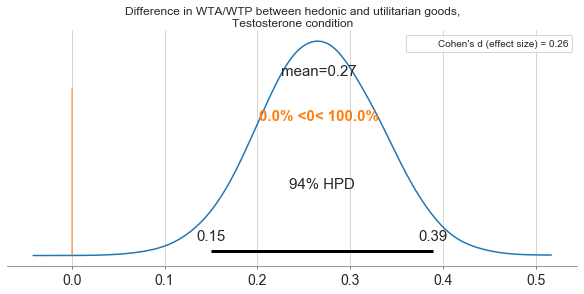

In [20]:
effect_size(trace_test, condition = 'Testosterone')    

## Testosterone related shift exploration
We can test existence of testosterone shift with the paired t-test, but we can do better, with the linear model and take into account item differences and individual differences

**Models**

 - model 0:  $$WTA_{item} \sim Normal(\mu_{item},\sigma_{item})$$
 with priors:
 $$\mu_{item} \sim $$




In [30]:
n_items = len(pd.unique(df.ItemCodes))
n_inds = len(pd.unique(df.SubjectsCode))

In [8]:
with pm.Model() as model_0:  
   
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 28)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = 28)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values])
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_0 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,789.6:   8%|▊         | 15899/200000 [00:04<00:55, 3342.90it/s]
Convergence achieved at 15900
Interrupted at 15,899 [7%]: Average Loss = 3,203.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_item]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 2755.68draws/s]


In [9]:
az.waic(trace_0)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 2057 log-likelihood matrix

        Estimate       SE
IC_waic  5468.92   154.83
p_waic    142.77        -

There has been a warning during the calculation. Please check the results.

In [10]:
with pm.Model() as model_1:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 28)
    sigma = pm.HalfCauchy('sigma', beta = 0.5, shape = 28)

    bT = pm.Normal('bT', mu = 0, sd = 1, shape = 28)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.Test)
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_1 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,839.1:   8%|▊         | 16899/200000 [00:05<01:00, 3030.68it/s]
Convergence achieved at 16900
Interrupted at 16,899 [8%]: Average Loss = 4,226.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigma, a_item]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:08<00:00, 1232.94draws/s]


In [11]:
az.waic(trace_1)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 2057 log-likelihood matrix

        Estimate       SE
IC_waic  5499.22   153.88
p_waic    165.15        -

There has been a warning during the calculation. Please check the results.

In [12]:
az.summary(trace_1,var_names=['bT'], credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bT[0],-0.18,0.13,-0.33,-0.03,0.0,0.0,7637.13,5512.56,7661.13,4810.41,1.0
bT[1],0.11,0.19,-0.10,0.33,0.0,0.0,7026.78,3741.71,7038.97,4413.13,1.0
bT[2],-0.45,0.27,-0.75,-0.13,0.0,0.0,7036.99,6405.15,7066.12,4827.76,1.0
bT[3],0.11,0.24,-0.15,0.39,0.0,0.0,7410.97,3891.30,7398.87,4757.71,1.0
bT[4],0.26,0.30,-0.07,0.61,0.0,0.0,7197.60,4796.28,7197.22,4549.47,1.0
bT[5],0.09,0.19,-0.14,0.31,0.0,0.0,7964.17,3998.31,7824.50,4672.28,1.0
bT[6],-0.01,0.37,-0.44,0.39,0.0,0.0,7200.11,2979.84,7191.48,4955.77,1.0
bT[7],-0.05,0.15,-0.21,0.13,0.0,0.0,9170.75,3207.28,9519.13,4816.32,1.0
bT[8],-0.22,0.19,-0.44,0.00,0.0,0.0,7535.45,5517.72,7494.30,4107.46,1.0
bT[9],0.07,0.12,-0.08,0.20,0.0,0.0,8834.06,3809.66,8805.37,4836.79,1.0


In [13]:
with pm.Model() as model_2:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 28)
    sigma = pm.HalfCauchy('sigma', beta = 0.5, shape = 28)

    bT = pm.Normal('bT', mu = 0, sd = 1, shape = 28)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change)
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_2 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,838.8:   8%|▊         | 15999/200000 [00:05<01:01, 2996.68it/s]
Convergence achieved at 16000
Interrupted at 15,999 [7%]: Average Loss = 4,354.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigma, a_item]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:06<00:00, 1577.28draws/s]


In [14]:
az.waic(trace_2)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 2057 log-likelihood matrix

        Estimate       SE
IC_waic  5491.55   154.47
p_waic    166.31        -

There has been a warning during the calculation. Please check the results.

In [15]:
az.summary(trace_2,var_names=['bT'], credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bT[0],-0.05,0.10,-0.17,0.06,0.0,0.0,5817.99,4057.67,5892.97,5167.21,1.0
bT[1],0.19,0.14,0.02,0.34,0.0,0.0,5966.16,5184.56,5968.27,4499.46,1.0
bT[2],-0.23,0.20,-0.45,-0.00,0.0,0.0,5479.53,4609.93,5478.28,4332.22,1.0
bT[3],0.24,0.18,0.02,0.43,0.0,0.0,5538.55,4712.34,5545.86,4535.17,1.0
bT[4],0.02,0.22,-0.24,0.27,0.0,0.0,4909.49,3305.52,4930.15,4247.61,1.0
bT[5],0.37,0.14,0.23,0.53,0.0,0.0,6123.46,5809.44,6133.51,4847.53,1.0
bT[6],-0.22,0.28,-0.55,0.10,0.0,0.0,4600.29,3563.19,4647.95,4327.97,1.0
bT[7],-0.05,0.11,-0.18,0.08,0.0,0.0,5683.56,3937.88,5677.83,4411.79,1.0
bT[8],-0.02,0.15,-0.19,0.14,0.0,0.0,5117.42,3222.16,5116.72,4158.43,1.0
bT[9],0.04,0.09,-0.06,0.15,0.0,0.0,6360.54,3945.67,6363.99,4801.32,1.0


In [17]:
with pm.Model() as model_3:  
    a_item  = pm.Normal('a_item', mu = 1, sd = 2, shape = 28)
    sigma = pm.HalfCauchy('sigma', beta = 0.5, shape = 28)
    sigmaInd = pm.HalfCauchy('sigmaInd', beta = 0.5, shape = 38)

    bT = pm.Normal('bT', mu = 0, sd = 1, shape = 28)
    mu = pm.Deterministic('mu', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change)
    
    WTAP = pm.Normal('WTAP', mu=mu, sd=sigma[df.ItemCodes.values]+sigmaInd[df.SubjectsCode.values], observed=df['WTAPcorr'].values)
    trace_3 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,646.7:   9%|▊         | 17099/200000 [00:06<01:06, 2753.42it/s]
Convergence achieved at 17100
Interrupted at 17,099 [8%]: Average Loss = 2,973.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigmaInd, sigma, a_item]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:09<00:00, 1019.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [18]:
az.summary(trace_3,var_names=['bT'], credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bT[0],0.09,0.09,-0.02,0.18,0.0,0.0,9575.08,5877.07,9552.21,4990.58,1.0
bT[1],0.10,0.09,-0.00,0.20,0.0,0.0,7886.09,5054.46,8127.55,5396.87,1.0
bT[2],-0.06,0.13,-0.21,0.08,0.0,0.0,8791.47,4504.30,8816.22,4985.15,1.0
bT[3],0.23,0.12,0.11,0.36,0.0,0.0,9718.76,7956.53,9765.18,4660.66,1.0
bT[4],-0.02,0.22,-0.27,0.23,0.0,0.0,9463.66,3566.82,9471.51,4985.75,1.0
bT[5],0.24,0.09,0.13,0.34,0.0,0.0,8454.62,7306.13,8521.05,5036.50,1.0
bT[6],-0.22,0.27,-0.50,0.12,0.0,0.0,9667.46,4866.47,9696.04,4386.96,1.0
bT[7],0.02,0.11,-0.09,0.15,0.0,0.0,8232.46,3301.55,8269.46,4599.49,1.0
bT[8],-0.02,0.09,-0.12,0.08,0.0,0.0,9931.99,3333.80,9959.10,4695.28,1.0
bT[9],0.02,0.09,-0.08,0.12,0.0,0.0,9446.67,3884.21,9431.20,5529.71,1.0


In [19]:
bT = trace_3['bT']
bT_hpd = pm.hpd(bT)

In [20]:
res_df = pd.DataFrame(df.groupby(['Item'])['ItemCodes'].min()).reset_index()
res_df['bT'] = bT.mean(0)
res_df['bT_low'] = bT_hpd.T[0]
res_df['bT_up'] = bT_hpd.T[1]
type_df = pd.DataFrame(df.groupby('Item')['Type'].min()).reset_index()
res_df = pd.merge(res_df,type_df)

In [21]:
hed = res_df[res_df.Type == 'h'].reset_index(drop=True)
ut = res_df[res_df.Type == 'u'].reset_index(drop=True)

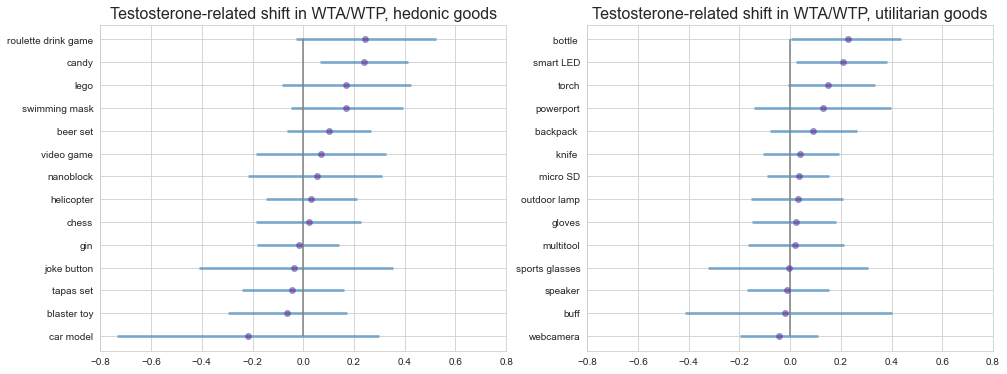

In [22]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
idx = np.argsort(hed.bT)
y_label = hed.loc[idx,'Item']
y_points = np.linspace(0, 1, len(idx))
x = hed.loc[idx,'bT'].values
xerr = np.abs(np.array([hed.loc[idx,'bT_low'].values,hed.loc[idx,'bT_up'].values])-x)
plt.errorbar(x,y_points,xerr = xerr,fmt='C0o', lw=3, alpha=0.5, mfc = 'purple')
plt.yticks(y_points, y_label);
plt.xlim(-0.8,0.8)
plt.vlines(0, 0, 1, 'grey');
plt.title('Testosterone-related shift in WTA/WTP, hedonic goods', size = 16);
plt.subplot(1,2,2)
idx = np.argsort(ut.bT)
y_label = ut.loc[idx,'Item']
y_points = np.linspace(0, 1, len(idx))
x = ut.loc[idx,'bT'].values
xerr = np.abs(np.array([ut.loc[idx,'bT_low'].values,ut.loc[idx,'bT_up'].values])-x)
plt.errorbar(x,y_points,xerr = xerr,fmt='C0o', lw=3, alpha=0.5, mfc = 'purple')
plt.yticks(y_points, y_label);
plt.xlim(-0.8,0.8)
plt.vlines(0, 0, 1, 'grey');
plt.title('Testosterone-related shift in WTA/WTP, utilitarian goods', size = 16);